In [160]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os

In [161]:
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,ExtraTreesClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRFClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

In [162]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm","numclaims"],axis=1)
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.06,0.303901,0.0,HBACK,3,F,C,2
1,1.03,0.648871,0.0,HBACK,2,F,A,4
2,3.26,0.569473,0.0,UTE,2,F,E,2
3,4.14,0.317591,0.0,STNWG,2,F,D,2
4,0.72,0.648871,0.0,HBACK,4,F,C,2


In [163]:
df=df.sort_values(by=['veh_age', 'agecat','area','gender']).reset_index().drop("index",axis=1)
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.59,0.229979,0.0,SEDAN,1,F,A,1
1,1.46,0.221766,0.0,HBACK,1,F,A,1
2,1.54,0.238193,0.0,SEDAN,1,F,A,1
3,1.57,0.522930,0.0,SEDAN,1,F,A,1
4,1.41,0.219028,0.0,HBACK,1,F,A,1


In [164]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

In [16]:
df=df[df["claimcst0"]>0]
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
14,1.66,0.484600,669.509999,9,2,1,1,5
16,1.51,0.993840,806.609999,9,2,0,5,3
17,0.76,0.539357,401.805451,3,2,1,2,3
40,1.89,0.654346,1811.709997,10,2,1,5,1
64,4.06,0.851472,5434.439987,10,1,1,5,2


In [165]:
x=df.drop("gender",axis=1)
y=df["gender"]

In [166]:
df["gender"].value_counts()

gender
0    38603
1    29253
Name: count, dtype: int64

In [167]:
from imblearn.over_sampling import SMOTE
smk=SMOTE(random_state=41)
x,y=smk.fit_resample(x,y)

In [168]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.25)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (57904, 7) and Y = (57904,) : 
Test data shape of X = (19302, 7) and Y = (19302,) : 


In [169]:
def evaluation_preds(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    precision=precision_score(y_true,predicted)
    recall=recall_score(y_true,predicted)
    f1=f1_score(y_true,predicted)
    metrics_dict={
       "accuracy": round(accuracy,3),
        "precision": round(precision,3),
        "recall":round(recall,3),
        "f1":round(f1,3)

    }
   
    return metrics_dict

In [170]:
models = {
        
        "XGBRFClassifier": XGBRFClassifier(),
        "GradientBoostingClassifier":GradientBoostingClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        "ExtraTreesClassifier": ExtraTreesClassifier(),
        "BaggingClassifier" :BaggingClassifier(),
        "KNeighborsClassifier": KNeighborsClassifier(),
        "SVC" :SVC(),
        "LogisticRegression" :LogisticRegression()        
}

search_spaces ={        
        "XGBRFClassifier":{
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),    # 0.3 is the default
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            "subsample": hp.uniform("subsample",0.5,1.0),
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            'colsample_bytree': hp.uniform("colsample_bytree",0.5,1.0), 
            'colsample_bynode': hp.uniform("colsample_bynode",0.5,1.0),
            "reg_lambda": hp.quniform("reg_lambda",0,2,1),           #L2 regularization term on weights. Increasing this value will make model more conservative
            "reg_alpha": hp.quniform("reg_alpha",0,2,1),
            "num_parallel_tree": hp.choice("num_parallel_tree", [100,110])
            },

        "GradientBoostingClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            "max_depth": hp.choice("max_depth", [None,2, 4, 5, 6,7,8]),
            "max_features": hp.choice("max_features",["sqrt", "log2"]),
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),
            "subsample": hp.uniform("subsample",0.8,1.0),
            "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
            "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0)
            },
                    
        "RandomForestClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]), 
            "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
            "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
            #"max_features": hp.choice("max_features",["sqrt", "log2"]),                                    
            "max_depth": hp.choice("max_depth", [None,2, 4, 5, 6,7,8])
            #"bootstrap": hp.choice("bootstrap",[True, False]),                                                                                                    
            #"criterion": hp.choice("criterion",["gini", "entropy", "log_loss"])                    
        },
        "AdaBoostClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            "learning_rate": hp.uniform("learning_rate",0.01,1.0)
        },
        "DecisionTreeClassifier": {
                    "criterion": hp.choice("criterion",["gini", "entropy", "log_loss"]),
                    'splitter': hp.choice("splitter",["best", "random"]),
                    "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
                    "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
                    "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
                    "max_features": hp.choice("max_features",["sqrt", "log2"])
        }                    
}

In [172]:

def basemodels():
    report={}
    for i in range(len(list(models))):
        clf=list(models.values())[i]
        clf.fit(x_train,y_train)
        predicted=clf.predict(x_test)
        evaluationPreds=evaluation_preds(y_test,predicted)
        report[list(models.keys())[i]] = (evaluationPreds)
        report_df=pd.DataFrame(report)
    return report_df

basemodels()

   

,XGBRFClassifier,GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,DecisionTreeClassifier,ExtraTreesClassifier,BaggingClassifier,KNeighborsClassifier,SVC,LogisticRegression
accuracy,0.622,0.623,0.631,0.619,0.581,0.628,0.617,0.615,0.500,0.589
precision,0.636,0.638,0.634,0.627,0.581,0.629,0.633,0.612,0.500,0.579
recall,0.570,0.569,0.623,0.587,0.583,0.625,0.557,0.632,0.946,0.656
f1,0.601,0.602,0.628,0.606,0.582,0.627,0.593,0.622,0.655,0.615


<Axes: >

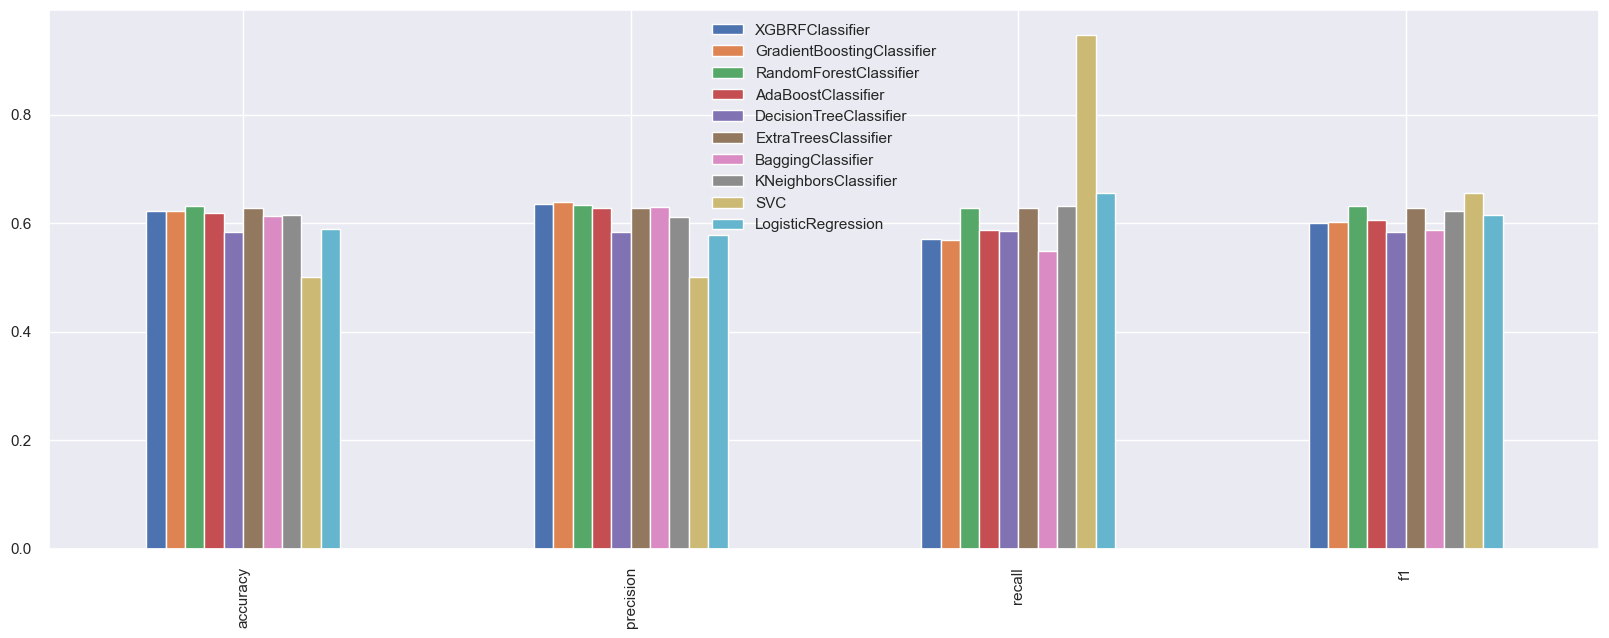

In [173]:
basemodels().plot(kind="bar",figsize=(20,7))

def hyperparameter_tuning():
    report = {}
    for i in range(len(list(models))):
        clf=list(models.values())[i]
        para=search_spaces[list(models.keys())[i]]
        clf.fit(x_train,y_train)
        acc = accuracy_score(y_test,clf.predict(x_test))
        report[list(models.keys())[i]]=acc
    return {"loss": report, "status": STATUS_OK}

hyperparameter_tuning()

In [157]:
np.random.seed(42)
clf = make_pipeline(StandardScaler(),RandomForestClassifier())
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
print(confusion_matrix(y_test,predicted))
evaluation_preds(y_test,predicted)

[[404 281]
 [235 404]]


{'accuracy': 0.61,
 'precision': np.float64(0.59),
 'recall': np.float64(0.632),
 'f1': np.float64(0.61)}

<Axes: ylabel='Count'>

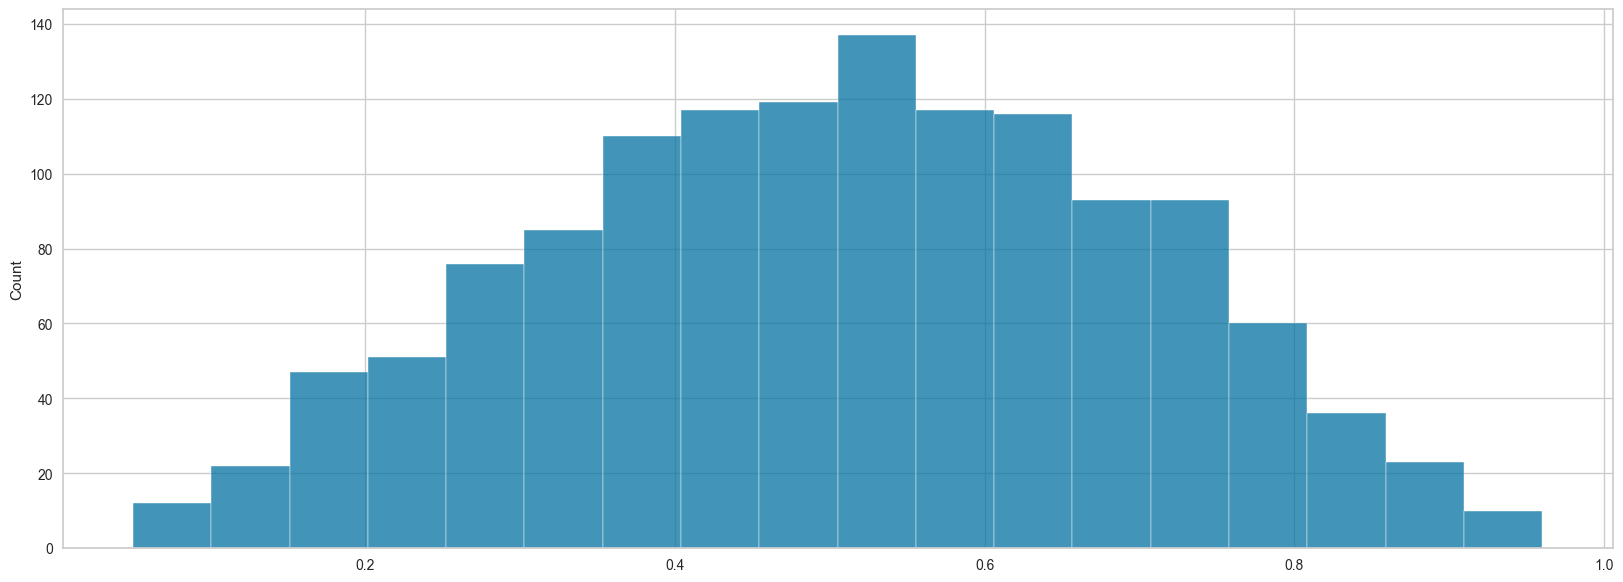

In [158]:
matplotlib.rcParams["figure.figsize"]=(20,7)
predicted_class=clf.predict_proba(x_test)
sns.histplot(predicted_class[:,1])

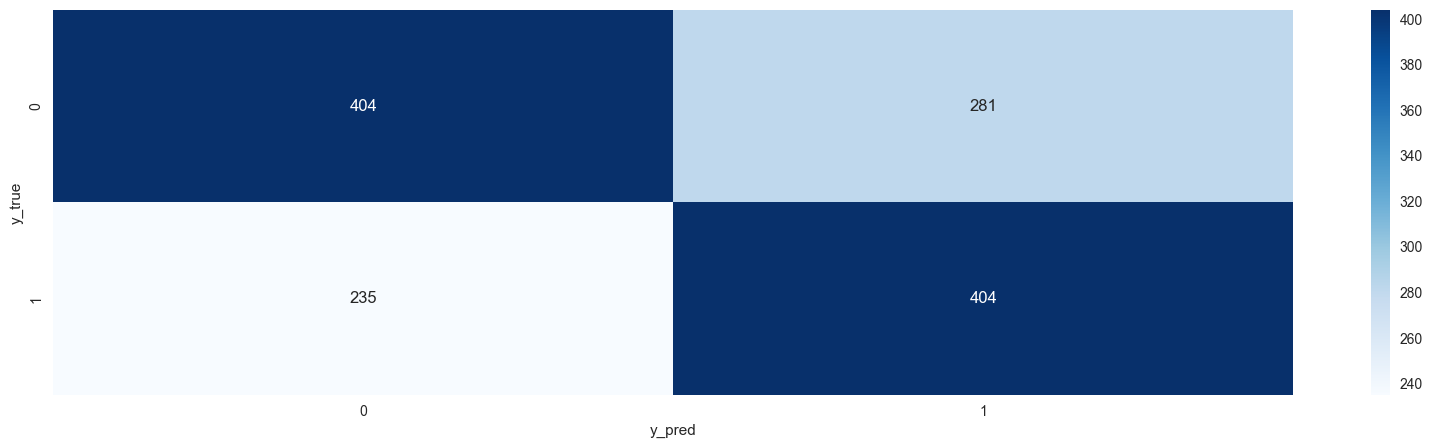

In [159]:
matplotlib.rcParams["figure.figsize"]=(20,5)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True,cmap="Blues",fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true");

In [84]:
from sklearn.ensemble import ExtraTreesClassifier
np.random.seed(42)
clf=make_pipeline(StandardScaler(),ExtraTreesClassifier())
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
print(confusion_matrix(y_test,predicted))
evaluation_preds(y_test,predicted)

[[6003 3599]
 [3663 6037]]


{'accuracy': 0.624,
 'precision': np.float64(0.627),
 'recall': np.float64(0.622),
 'f1': np.float64(0.624)}

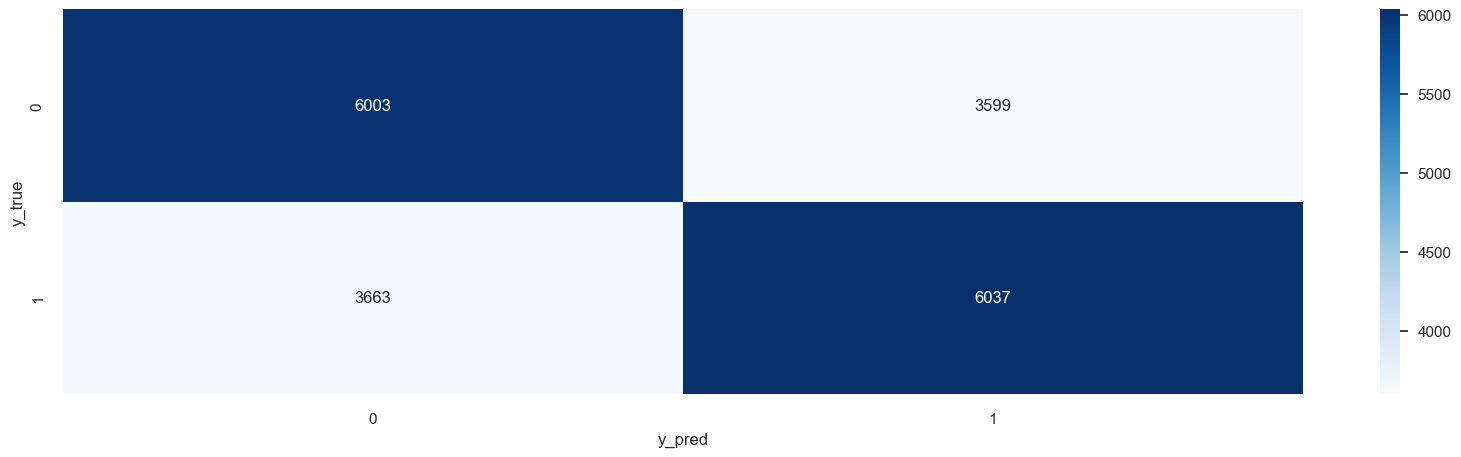

In [85]:
matplotlib.rcParams["figure.figsize"]=(20,5)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True,cmap="Blues",fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true");

In [47]:
from sklearn.ensemble import HistGradientBoostingClassifier
np.random.seed(42)
clf=HistGradientBoostingClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
print(clf.score(x_test,y_test))
print(confusion_matrix(y_test,predicted))
evaluation_preds(y_test,predicted)
#good

0.6125377643504532
[[443 242]
 [271 368]]


{'accuracy': 0.613,
 'precision': np.float64(0.603),
 'recall': np.float64(0.576),
 'f1': np.float64(0.589)}

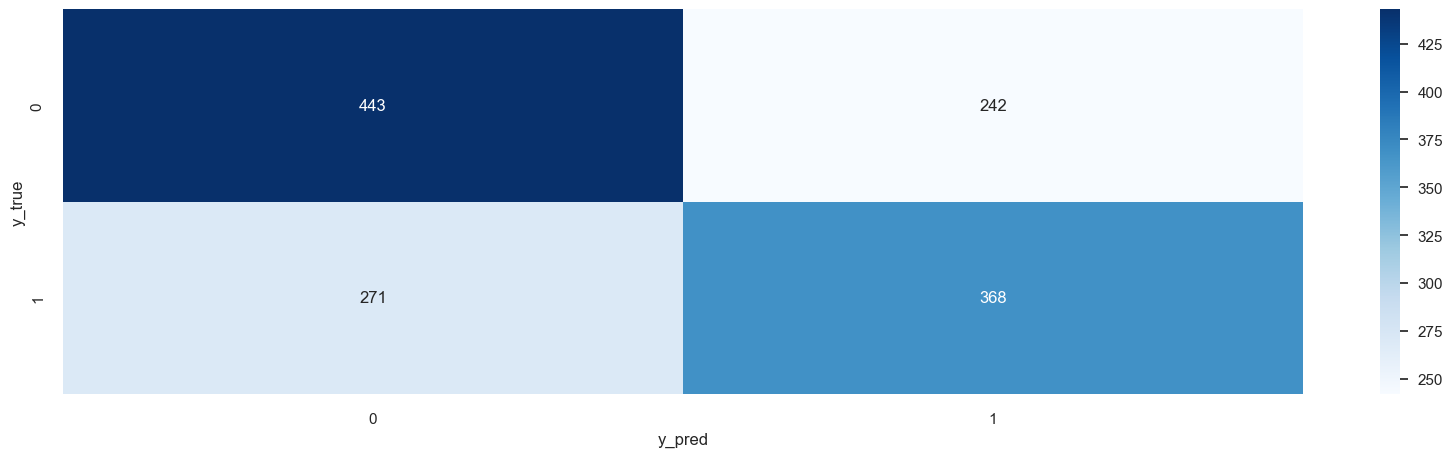

In [48]:
matplotlib.rcParams["figure.figsize"]=(20,5)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True,cmap="Blues",fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true");

In [86]:
np.random.seed(42)
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
clf=make_pipeline(StandardScaler(),
                  BaggingClassifier(RandomForestClassifier(),max_samples=0.9, max_features=0.9))

clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
print(clf.score(x_test,y_test))
print(confusion_matrix(y_test,predicted))
evaluation_preds(y_test,predicted)

0.6251683763340586
[[6148 3454]
 [3781 5919]]


{'accuracy': 0.625,
 'precision': np.float64(0.631),
 'recall': np.float64(0.61),
 'f1': np.float64(0.621)}

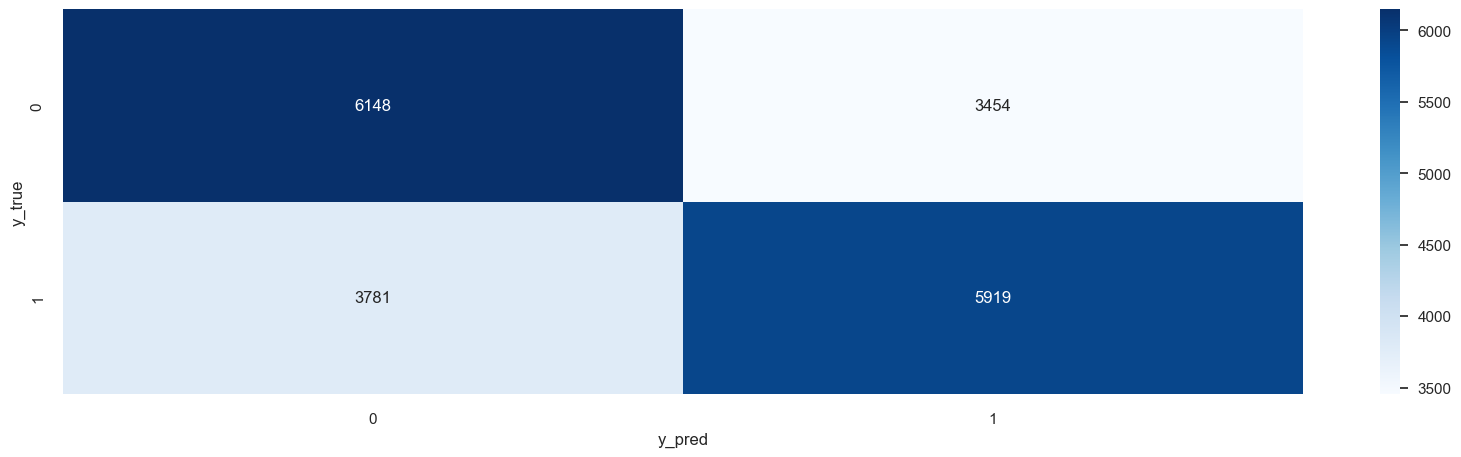

In [87]:
matplotlib.rcParams["figure.figsize"]=(20,5)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True,cmap="Blues",fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true");

In [88]:
np.random.seed(42)
clf = clf=make_pipeline(StandardScaler(),
                  BaggingClassifier(KNeighborsClassifier(),max_samples=0.9, max_features=0.9))
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
print(clf.score(x_test,y_test))
print(confusion_matrix(y_test,predicted))
evaluation_preds(y_test,predicted)

0.6110247642731323
[[6031 3571]
 [3937 5763]]


{'accuracy': 0.611,
 'precision': np.float64(0.617),
 'recall': np.float64(0.594),
 'f1': np.float64(0.606)}

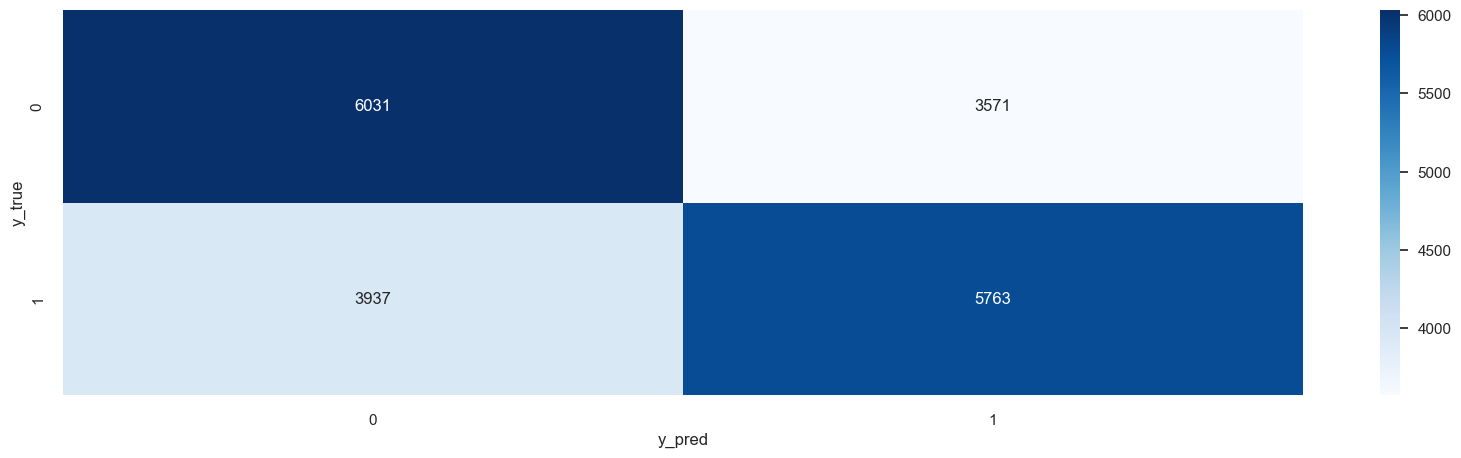

In [89]:
matplotlib.rcParams["figure.figsize"]=(20,5)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True,cmap="Blues",fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true");

In [90]:
np.random.seed(42)
from sklearn.svm import LinearSVC
clf = make_pipeline(StandardScaler(),LinearSVC())
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
print(clf.score(x_test,y_test))
print(confusion_matrix(y_test,predicted))
evaluation_preds(y_test,predicted)

0.5877629261216454
[[4871 4731]
 [3226 6474]]


{'accuracy': 0.588,
 'precision': np.float64(0.578),
 'recall': np.float64(0.667),
 'f1': np.float64(0.619)}

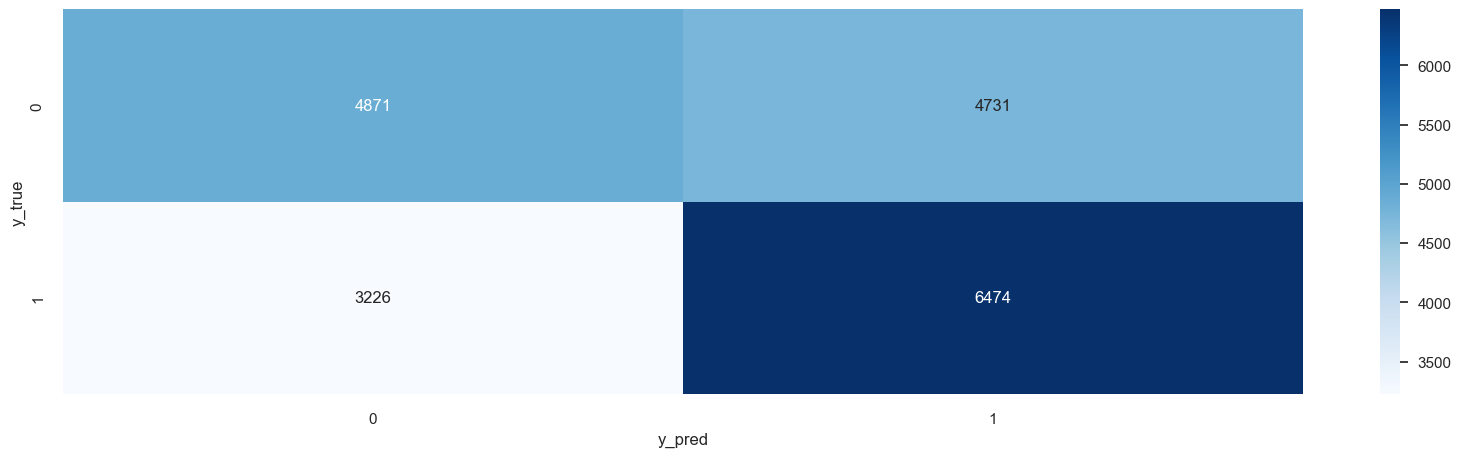

In [91]:
matplotlib.rcParams["figure.figsize"]=(20,5)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True,cmap="Blues",fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true");

In [92]:
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(),
              SVC(kernel="rbf",probability=True))
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
print(clf.score(x_test,y_test))
print(confusion_matrix(y_test,predicted))
evaluation_preds(y_test,predicted)


In [59]:
clf.predict_proba(x_test)[:,1]

array([0.37032164, 0.3113989 , 0.40323098, ..., 0.75297047, 0.63310811,
       0.38309349])

<Axes: ylabel='Count'>

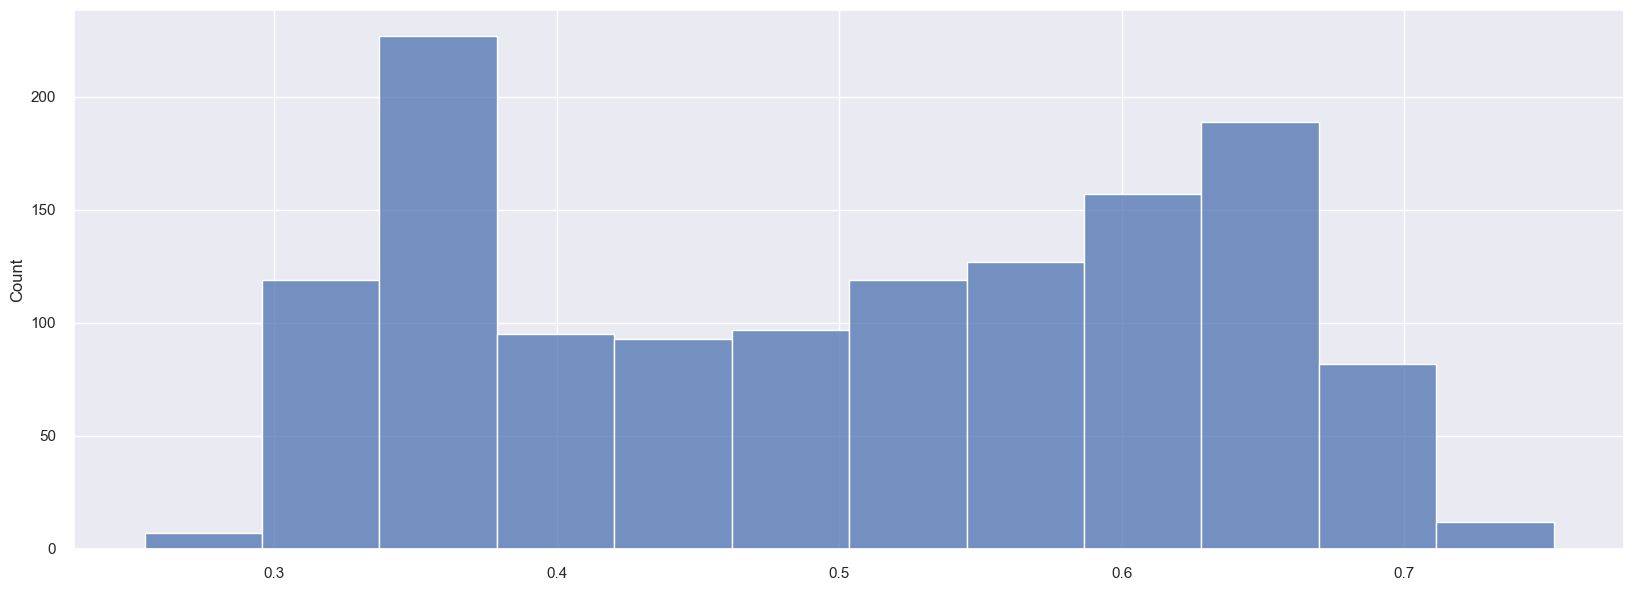

In [60]:
matplotlib.rcParams["figure.figsize"]=(20,7)
predicted_class=clf.predict_proba(x_test)
sns.histplot(predicted_class[:,1])

In [152]:
from sklearn.preprocessing import binarize
y_pre_class=binarize(X=[predicted_class[:,1]],threshold=.35)[0]
print(confusion_matrix(y_test,y_pre_class))
evaluation_preds(y_test,y_pre_class)

[[319 351]
 [145 341]]


{'accuracy': 0.571,
 'precision': np.float64(0.493),
 'recall': np.float64(0.702),
 'f1': np.float64(0.579)}

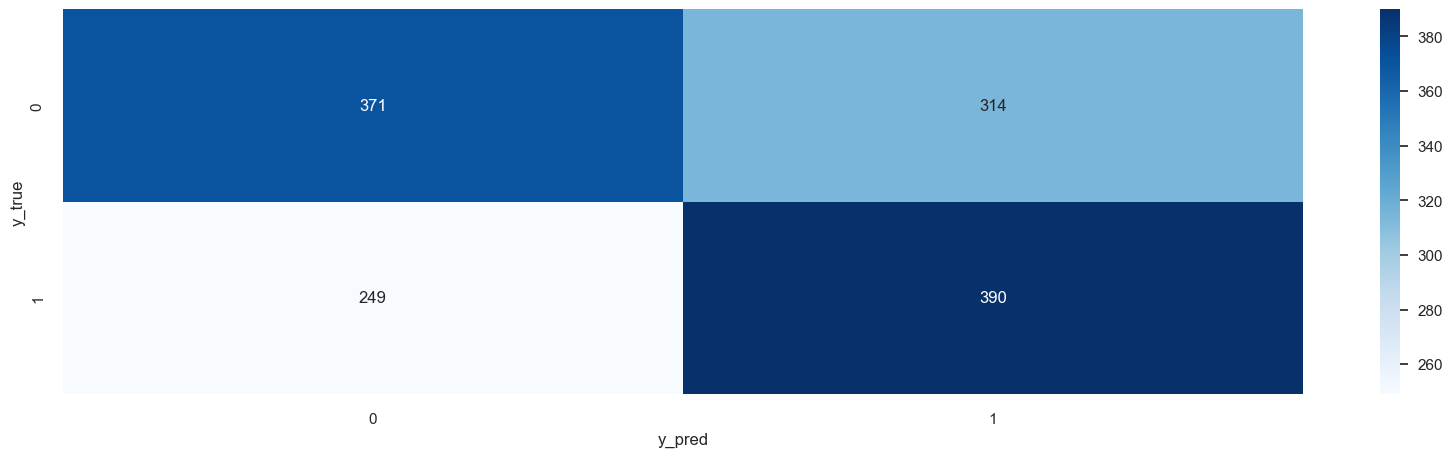

In [61]:
matplotlib.rcParams["figure.figsize"]=(20,5)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True,cmap="Blues",fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true");

In [62]:
from sklearn.linear_model import LogisticRegression
clf = make_pipeline(StandardScaler(),
              LogisticRegression())
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
print(clf.score(x_test,y_test))
print(confusion_matrix(y_test,predicted))
evaluation_preds(y_test,predicted)

0.5785498489425982
[[356 329]
 [229 410]]


{'accuracy': 0.579,
 'precision': np.float64(0.555),
 'recall': np.float64(0.642),
 'f1': np.float64(0.595)}

<Axes: ylabel='Count'>

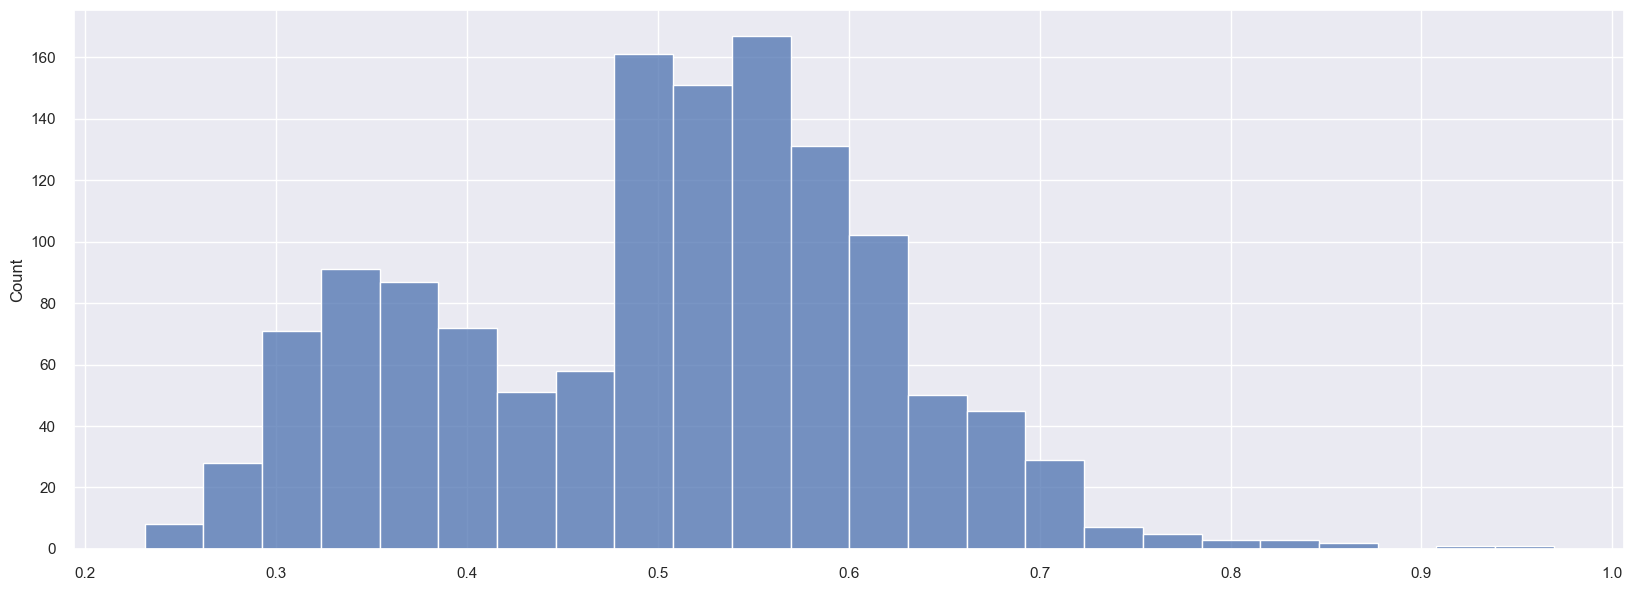

In [63]:
matplotlib.rcParams["figure.figsize"]=(20,7)
predicted_class=clf.predict_proba(x_test)
sns.histplot(predicted_class[:,1])

In [68]:
from sklearn.preprocessing import binarize
y_pre_class=binarize(X=[predicted_class[:,1]],threshold=.45)[0]
print(confusion_matrix(y_test,y_pre_class))
evaluation_preds(y_test,y_pre_class)

[[261 424]
 [150 489]]


{'accuracy': 0.566,
 'precision': np.float64(0.536),
 'recall': np.float64(0.765),
 'f1': np.float64(0.63)}

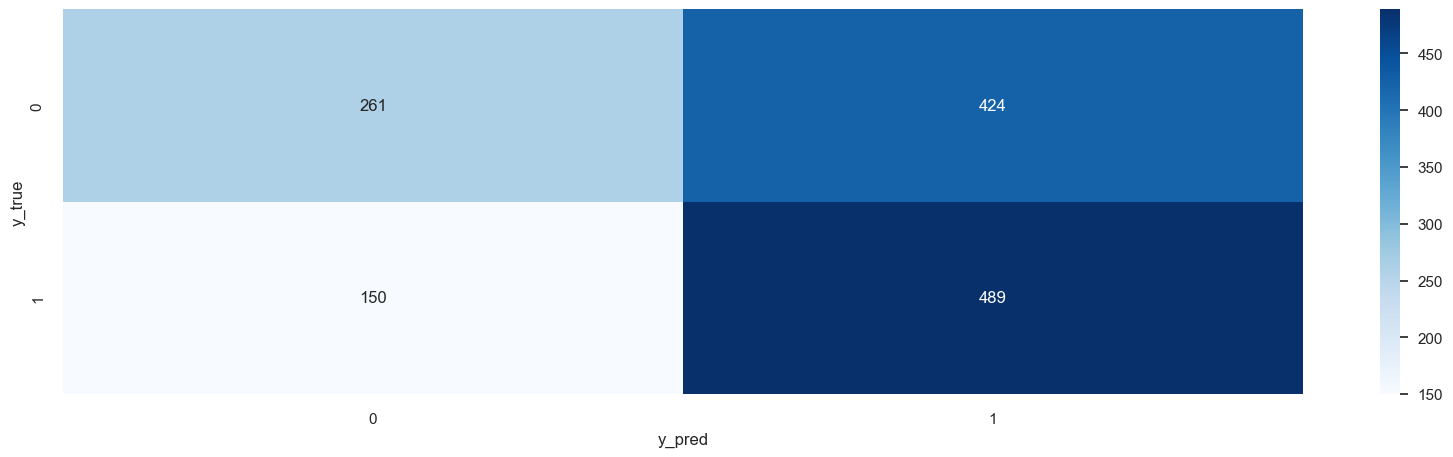

In [69]:
matplotlib.rcParams["figure.figsize"]=(20,5)
sns.heatmap(confusion_matrix(y_test,y_pre_class),annot = True,cmap="Blues",fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true");